In [6]:
import math
from draw_graph import *
import random

In [75]:

class Value:
    def __init__(self, val, _parents=(), _op='', _label='value'):
        
        self.val = val
        self._prev = set(_parents)
        self._op = _op
        self.grad = 0.0
        self._label = _label
        self._backward = lambda: None

    

    def __add__(self, another_value):
        #Make sure we manipulate with Value instances
        another_value = another_value if isinstance(another_value, Value) else Value(another_value)
        
        
        #We need to accumulate gradients
        #It fixex the problem when we overwrite grad
        #when this node is used multiple times
        result = self.val + another_value.val
        out = Value(result, _parents=(self, another_value), _op='+')
        
        #Define function for backprop for sum
        def _backward():
            
            self.grad += out.grad
            another_value.grad += out.grad
        
        out._backward = _backward
        
        
        return out
    
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, another_value):
        return self + (-another_value)
    
    
    def __truediv__(self, another_value):
        return self * (another_value ** -1)
    
    def __mul__(self, another_value):
        #Make sure we manipulate with Value instances
        another_value = another_value if isinstance(another_value, Value) else Value(another_value)
                
        result = self.val * another_value.val
        out = Value(result, _parents=(self, another_value), _op='*')
        
        def _backward():
            self.grad += another_value.val * out.grad
            another_value.grad += self.val * out.grad
            
        out._backward = _backward
    
        return out
    
    def __rmul__(self, another_value):
        return self * another_value
    
    def __radd__(self, another_value):
        return self + another_value
    
    def __rsub__(self, another_value):
        
        another_value = another_value if isinstance(another_value, Value) else Value(another_value)
        
        return another_value + (-self)
    
    
    def tanh(self):
        val = (math.exp(2 * self.val) - 1) / (math.exp(2 * self.val) + 1)
        
        out = Value(val, _parents=(self, ), _op='tanh')
        
        def _backward():
            self.grad +=  (1 - out.val ** 2) * out.grad
            
        out._backward = _backward
        
        return out
    
    
    def __pow__(self, another_value):
        assert isinstance(another_value, (int, float)), "only int or float expected"
        
        out = Value(self.val ** another_value, _parents=(self, ), _op=f"^{another_value}")
        
        def _backward():
            self.grad += (another_value * self.val ** (another_value - 1)) * out.grad
            
        out._backward = _backward
        
        
        return out
        
    
    
    def exp(self):
        
        result = math.exp(self.val)
        out = Value(result, _parents=(self,), _op="exp")
        
        def _backward():
            self.grad += result * out.grad
            
        out._backward = _backward
        return out
    
    
    def backward(self):
        
        self.grad = 1
        
        topo = []
        visited = set()

        #Topological sorting
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for parent in v._prev:
                    build_topo(parent)
                topo.append(v)
         
        build_topo(self)
        
        #go through node and call _backward()
        for node in reversed(topo):
            node._backward()
            
    def __repr__(self):
        return f"Value(val={self.val}, label={self._label})"


In [76]:




w1 = Value(-3, _label="w1")
x1 = Value(2, _label="x1")

w2 = Value(1, _label="w2")
x2 = Value(0, _label="x1")

b = Value(6.88137)

x1w1 = x1 * w1
x2w2 = x2 * w2

together = x1w1 + x2w2

n = together + b
#fin = n.tanh()

# e_z = (2*n).exp()
# tanh_fin = (e_z - 1) / (e_z + 1)


tanh_fin = n.tanh()

tanh_fin.backward()

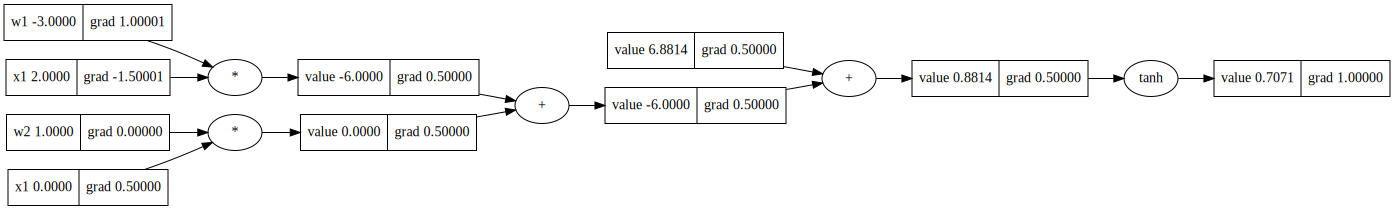

In [77]:
draw_dot(tanh_fin)

In [287]:
class Neuron:
    def __init__(self, n_inputs):
        
        self.w = [Value(random.uniform(-1, 1)) for  i in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))
        
        
    def __call__(self, x):
        self.z = sum( (wi * xi for wi, xi in zip(self.w, x)) ) + self.b
        self.a = self.z.tanh()
        
        
        return self.a
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    def __init__(self, n_inputs, units):
        self.neurons = [Neuron(n_inputs) for _ in range(units)]
        
    def __call__(self, inputs):
        self.output = [ni(inputs) for ni in self.neurons]
        
        return self.output[0] if len(self.output) == 1 else self.output
    
    def parameters(self):
        
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
            
        return params
    
    
class MLP:
    def __init__(self, n_inputs, layers_sizes):
        self.sizes = [n_inputs] + layers_sizes
        
        self.layers = [Layer(self.sizes[i], self.sizes[i+1]) for i in range(len(layers_sizes))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self):
        params = []
        
        for layer in self.layers:
            params.extend(layer.parameters())
            
        return params
    
        
    
    

In [291]:


nn = MLP(3, [4, 2, 1])




In [292]:
data = [[2.0, 3.0, -1],
        [-1, 0, 2],
        [1.5, 2.4, 0],
        [-2, -1, 3]
       ]

targets = [1, -1,  1, -1]

In [294]:
alpha = 0.01
epochs = 10

for ep in range(epochs):
    
    
    preds = [nn(x) for x in data]
    
    mse = sum([(preds[i] - targets[i]) ** 2 for i in range(len(data))])
    mse.backward()
    
    print(f"Epoch {ep} MSE = ", mse)
    
    #Updating params
    params = nn.parameters()
    for p in params:
        p.val -= alpha * p.grad

Epoch 0 MSE =  Value(val=1.1855233897657453, label=value)
Epoch 1 MSE =  Value(val=0.8989978365492314, label=value)
Epoch 2 MSE =  Value(val=0.5512264342585121, label=value)
Epoch 3 MSE =  Value(val=0.27715027472219506, label=value)
Epoch 4 MSE =  Value(val=0.11948096112826215, label=value)
Epoch 5 MSE =  Value(val=0.04653618757418096, label=value)
Epoch 6 MSE =  Value(val=0.01705947965654203, label=value)
Epoch 7 MSE =  Value(val=0.006043110183975934, label=value)
Epoch 8 MSE =  Value(val=0.0021018982285695206, label=value)
Epoch 9 MSE =  Value(val=0.0007252026425336857, label=value)


In [296]:
nn([2, 3, -1])

Value(val=0.9890230661474004, label=value)